# AirBnB : Part 2, Model Selection ALL CITIES

In [36]:
%matplotlib inline 

import matplotlib.pyplot as plt

from time import time
import numpy as np
import pandas as pd

import seaborn as sns

import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,RandomizedLogisticRegression

from sklearn.svm import SVC
from sklearn.metrics import r2_score, mean_squared_error,confusion_matrix,classification_report,roc_curve,auc
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.grid_search import GridSearchCV


from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,LabelEncoder

from xgboost import XGBClassifier
from utils import rstr,distance

import pickle

airBColor= '#ff5a5f'
airBColor2= '#008489'

In [2]:
df = pd.read_csv('../../data/all_cities/dataset_for_modeling.csv')

In [3]:
features_RLR =  pickle.load(open('best_features/features_RLR.p', 'rb'))
features_Kbest_chi2=  pickle.load(open('best_features/features_Kbest_chi2.p', 'rb'))
features_Kbest_fclass=  pickle.load(open('best_features/features_Kbest_fclass.p', 'rb'))
features_XBOOST =  pickle.load(open('best_features/XGB_features.p', 'rb'))
all_features = pickle.load(open('best_features/best_features.p', 'rb'))

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
features_ALL = df.select_dtypes(include=numerics).columns.tolist()

In [4]:
df.shape

(3443, 183)

In [5]:
df=df[['multihost']+ all_features]

In [6]:
df.shape

(3443, 183)

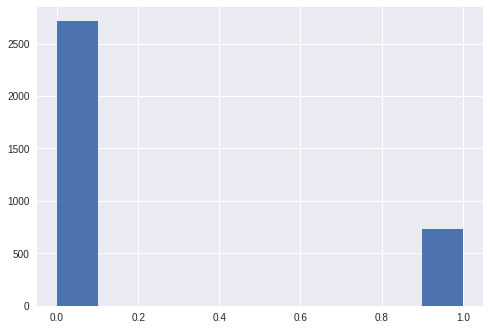

In [7]:
df.multihost.hist()

### Filter on listings with high reviews number

### Fill the missing data

In [8]:
df_missing_data = pd.DataFrame(df.isnull().sum()/len(df)*100).sort_values(by=0,ascending=False)
df_missing_data.columns = ['missing_percent']
df_missing_data = df_missing_data[df_missing_data.missing_percent>0]
df_missing_data

,missing_percent


## Linear Model and R-squared

In [9]:
TARGET_CLASSIFICATION ='multihost'
y = df[TARGET_CLASSIFICATION]

X = df.drop(TARGET_CLASSIFICATION,axis=1)

### Train test split

In [10]:
def balanced_subsample(y, size=None):

    subsample = []

    if size is None:
        n_smp = y.value_counts().min()
    else:
        n_smp = int(size / len(y.value_counts().index))

    for label in y.value_counts().index:
        samples = y[y == label].index.values
        index_range = range(samples.shape[0])
        indexes = np.random.choice(index_range, size=n_smp, replace=False)
        subsample += samples[indexes].tolist()

    return subsample

In [11]:
rebalanced_index = balanced_subsample(y)

In [12]:
X,y = X.loc[rebalanced_index],y.loc[rebalanced_index]

In [13]:
y.value_counts()

1    728
0    728
Name: multihost, dtype: int64

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2)
features = pd.Series(X.columns)
#scaler = MinMaxScaler()

#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)
print y_test.value_counts()

1    158
0    134
Name: multihost, dtype: int64


In [15]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=params, cv=n_folds, n_jobs=-1,scoring="recall")
    gs.fit(Xtrain, ytrain)
    
    return gs.best_estimator_

### Logistic Regression

In [40]:
clf = LogisticRegression(C=1e5)
clf.fit(X_train,y_train)
prediction = clf.predict(X_test)
print confusion_matrix(y_test,prediction)
print classification_report(y_test,prediction)

cv_scores =cross_val_score(clf, X_test, y_test, cv=5, scoring='recall')
print("Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

[[ 99  35]
 [ 41 117]]
             precision    recall  f1-score   support

          0       0.71      0.74      0.72       134
          1       0.77      0.74      0.75       158

avg / total       0.74      0.74      0.74       292

Accuracy: 0.72 (+/- 0.32)


### Random Forest

In [17]:
clf = RandomForestClassifier()
params={}
best_clf = cv_optimize(clf,params,X_train,y_train)

print(best_clf)

prediction = best_clf.predict(X_test)
print confusion_matrix(y_test,prediction)
print classification_report(y_test,prediction)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
[[103  31]
 [ 59  99]]
             precision    recall  f1-score   support

          0       0.64      0.77      0.70       134
          1       0.76      0.63      0.69       158

avg / total       0.70      0.69      0.69       292



### MLP

In [18]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(10, 5), random_state=1,learning_rate='adaptive')
 
best_clf = clf.fit(X_train,y_train)

prediction = best_clf.predict(X_test)

print confusion_matrix(y_test,prediction)

print classification_report(y_test,prediction)

[[ 95  39]
 [ 58 100]]
             precision    recall  f1-score   support

          0       0.62      0.71      0.66       134
          1       0.72      0.63      0.67       158

avg / total       0.67      0.67      0.67       292



/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


### XGB

In [19]:
params = {
    'max_depth':15,
    'min_child_weight':1,
    'learning_rate' :0.1,
    'gamma':0.0,
    'n_estimators':500
}

print params

clf = XGBClassifier(**params)

#best_clf = cv_optimize(clf,params,X_train,y_train)
best_clf = clf.fit(X_train,y_train)
print(best_clf)

{'n_estimators': 500, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 1}
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=15,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [20]:
prediction = best_clf.predict_proba(X_test)
print prediction[:,1]
print confusion_matrix(y_test,prediction[:,1]>.5)

print classification_report(y_test,prediction[:,1]>.5)

[  9.95200038e-01   9.84078884e-01   9.70012367e-01   9.99021053e-01
   9.99853969e-01   9.50013518e-01   3.64027888e-01   5.73312528e-02
   9.96842384e-01   9.34287548e-01   9.25757289e-01   1.16250701e-01
   3.34645374e-05   8.23285878e-01   9.37629342e-01   7.25489557e-02
   7.20588025e-04   9.96615827e-01   9.58190918e-01   9.00009394e-01
   9.99207079e-01   9.99234617e-02   4.09505703e-03   9.41872224e-03
   8.84409308e-01   8.99310291e-01   1.93037122e-04   9.82765913e-01
   5.16979070e-03   9.40669477e-01   1.37042686e-01   1.13952225e-02
   3.02272907e-04   1.29102287e-03   9.96771276e-01   9.97270644e-01
   2.49890308e-03   9.82169449e-01   9.57269132e-01   9.99522805e-01
   7.91289568e-01   9.39069271e-01   6.56930208e-02   9.99243259e-01
   3.29527003e-03   9.63026378e-03   4.85838464e-05   9.18613136e-01
   9.72665966e-01   1.16909780e-01   9.63677764e-01   9.93362904e-01
   4.51708287e-02   7.57138073e-01   1.36010543e-01   4.01662230e-01
   9.69457254e-03   7.91998684e-01

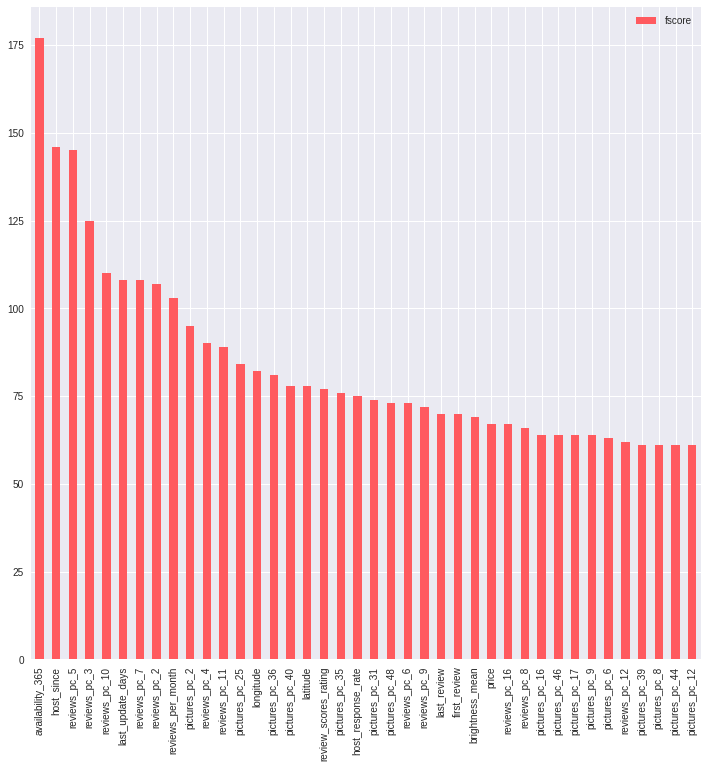

In [21]:
features_weights = pd.DataFrame.from_dict(best_clf.booster().get_fscore(),orient="index")
features_weights.columns = ['fscore']

features_weights.sort_values(by='fscore',ascending=False).head(40).plot(kind='bar',title='',color=airBColor,figsize=(12,12))

### Plot ROC Curve

In [49]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=10, proba=True, skip=1):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in xrange(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        print threshold
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

1.0
0.98
0.83
0.72
0.64
0.47
0.28
0.09
0.03
0.0


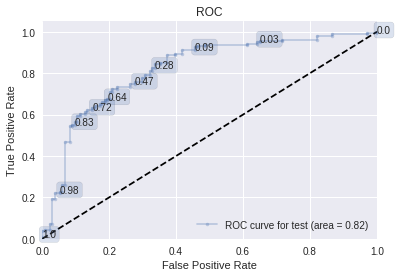

In [50]:
make_roc('test',best_clf,y_test,X_test)